# Mineração de Dados - BCC-444

### **Trabalho Prático**

Pablo Martins Coelho - 20.1.4113

Rafael Augusto Freitas Oliveira - 20.1.4038

Robson Novato Lobão - 20.1.4018

#Limpeza e transformação de dados do desafio das empresas na Rússia
O desafio do Kaggle pode ser encontrado no seguinte link: https://www.kaggle.com/datasets/vadimtynchenko/list-of-companies-leaving-or-staying-in-russia

Inicialmente será feita uma análise descritiva do desafio:

# Identificando os tipos de atributos (contínuos , discretos, binários (simétricos ou assimétricos), categóricos (nominais ou ordinais)).

* Name: Nome da companhia, **categórico nominal** pois rotula uma companhia mas sem distinção de hierarquia, apenas nomeia.

* Action: Ação da empresa, indica o que a empresa anunciou, é um atributo **categórico nominal**, pois rotula o local da empresa, mas não tem uma ordem entre os locais.

* Indutry: Indústria, indica qual o tipo de indústria é a companhia. É um atributo **categórico nominal**, pois classifica o tipo de indústria e não tem uma ordem específica entre esses tipos.

* Country: País, representa o endereço legal da empresa. Atributo **categórico nominal**, pois apenas indica o país de origem da empresa.

* Grade: Nota, representa uma escala de notas de A a F para a completude da abstinência da companhia. Representa um atributo **categórico ordinal**, categórico pois rotula em diferentes classes e ordinal por haver hierarquia entre os dados.


# Para os atributos nominais e ordinais, é indicado quais seus possíveis valores e a popularidade (distribuição de probabilidade) de cada.

In [869]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

from collections import defaultdict


dataframe = pd.read_csv('companies.csv')

originalDataFrame = copy.deepcopy(dataframe)

dataframe.head()

,Name,Action,Industry,Country,Grade
0,Agrana,continue operating plant in Russia,Consumer Staples,Austria,F
1,Agricultural Bank of China,Russian companies open accounts with the bank;...,Financials,China,F
2,Air China,still flying to Russia,Industrials,China,F
3,Air Serbia,still flying to Russia,Industrials,Serbia,F
4,Alibaba,still operating in Russia,Consumer Discretionary,China,F


Os atributos explorados são os categóricos nominais Action, Industry e Country e o categórico ordinal Grade.


In [870]:
def distribuicaoDeProbabilidade(atributo):
  distribuicao = dataframe[atributo].value_counts(normalize=True)
  print(distribuicao)
  print("\n\n")

print("\nAção anunciada pela empresa\n")
distribuicaoDeProbabilidade("Action")
print("Tipos de Indústrias\n")
distribuicaoDeProbabilidade("Industry")
print("País de origem da empresa\n")
distribuicaoDeProbabilidade("Country")
print("Níveis de completude de abstinência\n")
distribuicaoDeProbabilidade("Grade")


Ação anunciada pela empresa

still operating in Russia                                                                  0.033523
suspend operations in Russia                                                               0.029096
Fully exit Russia after selling its operations                                             0.026565
suspend all shipments to Russia                                                            0.025300
Business as usual                                                                          0.018343
                                                                                             ...   
stopped all operations in Russia other than basic food/feed/essential health activities    0.000633
suspend certain partnerships with Aeroflot                                                 0.000633
suspend exports and imports but not local operations                                       0.000633
stop all sales to Russia and shut down cloud operations but some carve

Através da análise dos possíveis valores dos atributos explorados, é possível observar que a maioria das companhias são Industrias, logo após vem outros setores que têm uma menor porcentagem, sendo em sua menor quantidade as companhias Imobiliárias. 
Com relação às ações anunciadas pelas empresas, uma grande parte dos anúncios é que as empresas ainda estão operando, e em seguida é que as empresas vão suspender as operações na Rússia.
É possível ver também que uma boa parte das empresas operando na Rússia são dos Estados Unidos.
Sobre os níveis de completure de abstinência, é possível notar que a maioria das empresas têm o nível A e o nível B de abstinência.

# Identificação dos valores ausentes (isna ou isnull), aberrantes e inconsistências.

In [871]:
# Exemplo de atributo categórico ordinal
atributo = dataframe["Grade"].values

# Definir a ordem das categorias
ordem = ["F","E","D","C","B","A"]

# Criar um dicionário de mapeamento
mapeamento = {cat: i for i, cat in enumerate(ordem)}

# Removendo a coluna original
dataframe.drop('Grade', axis=1, inplace=True)

# Mapear as categorias para valores numéricos
dataframe['Grade'] = [mapeamento[cat] for cat in atributo]

# Imprimir o atributo numérico
dataframe.head()

,Name,Action,Industry,Country,Grade
0,Agrana,continue operating plant in Russia,Consumer Staples,Austria,0
1,Agricultural Bank of China,Russian companies open accounts with the bank;...,Financials,China,0
2,Air China,still flying to Russia,Industrials,China,0
3,Air Serbia,still flying to Russia,Industrials,Serbia,0
4,Alibaba,still operating in Russia,Consumer Discretionary,China,0


Uma forma de identificar valores aberrantes é verificando a média de evasão do país em geral e ver se a empresa correspondente está mais ou menos semelhante, por exemplo, sendo 5 a total evasão da Russia e 0 a permanência total das atividades a média está em 0.6, ou seja, países chineses que tem valores acima de 4 ou até mesmo 5 podem ser aberrantes.

0.6923076923076923


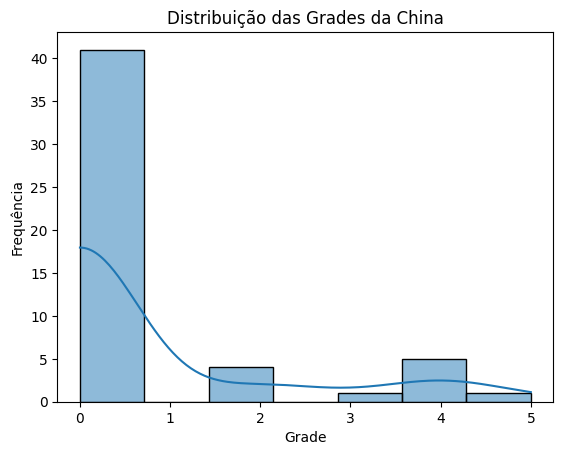

3.7964989059080962


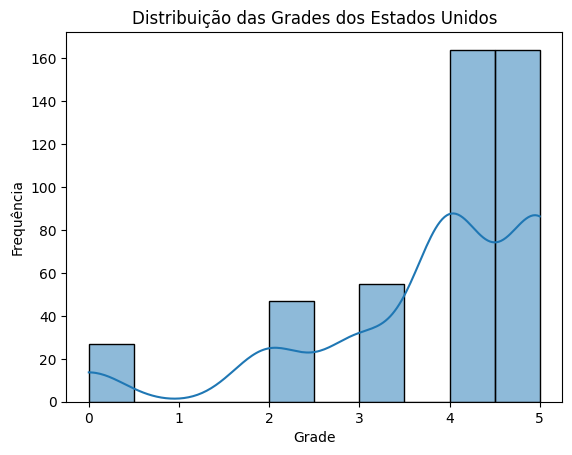

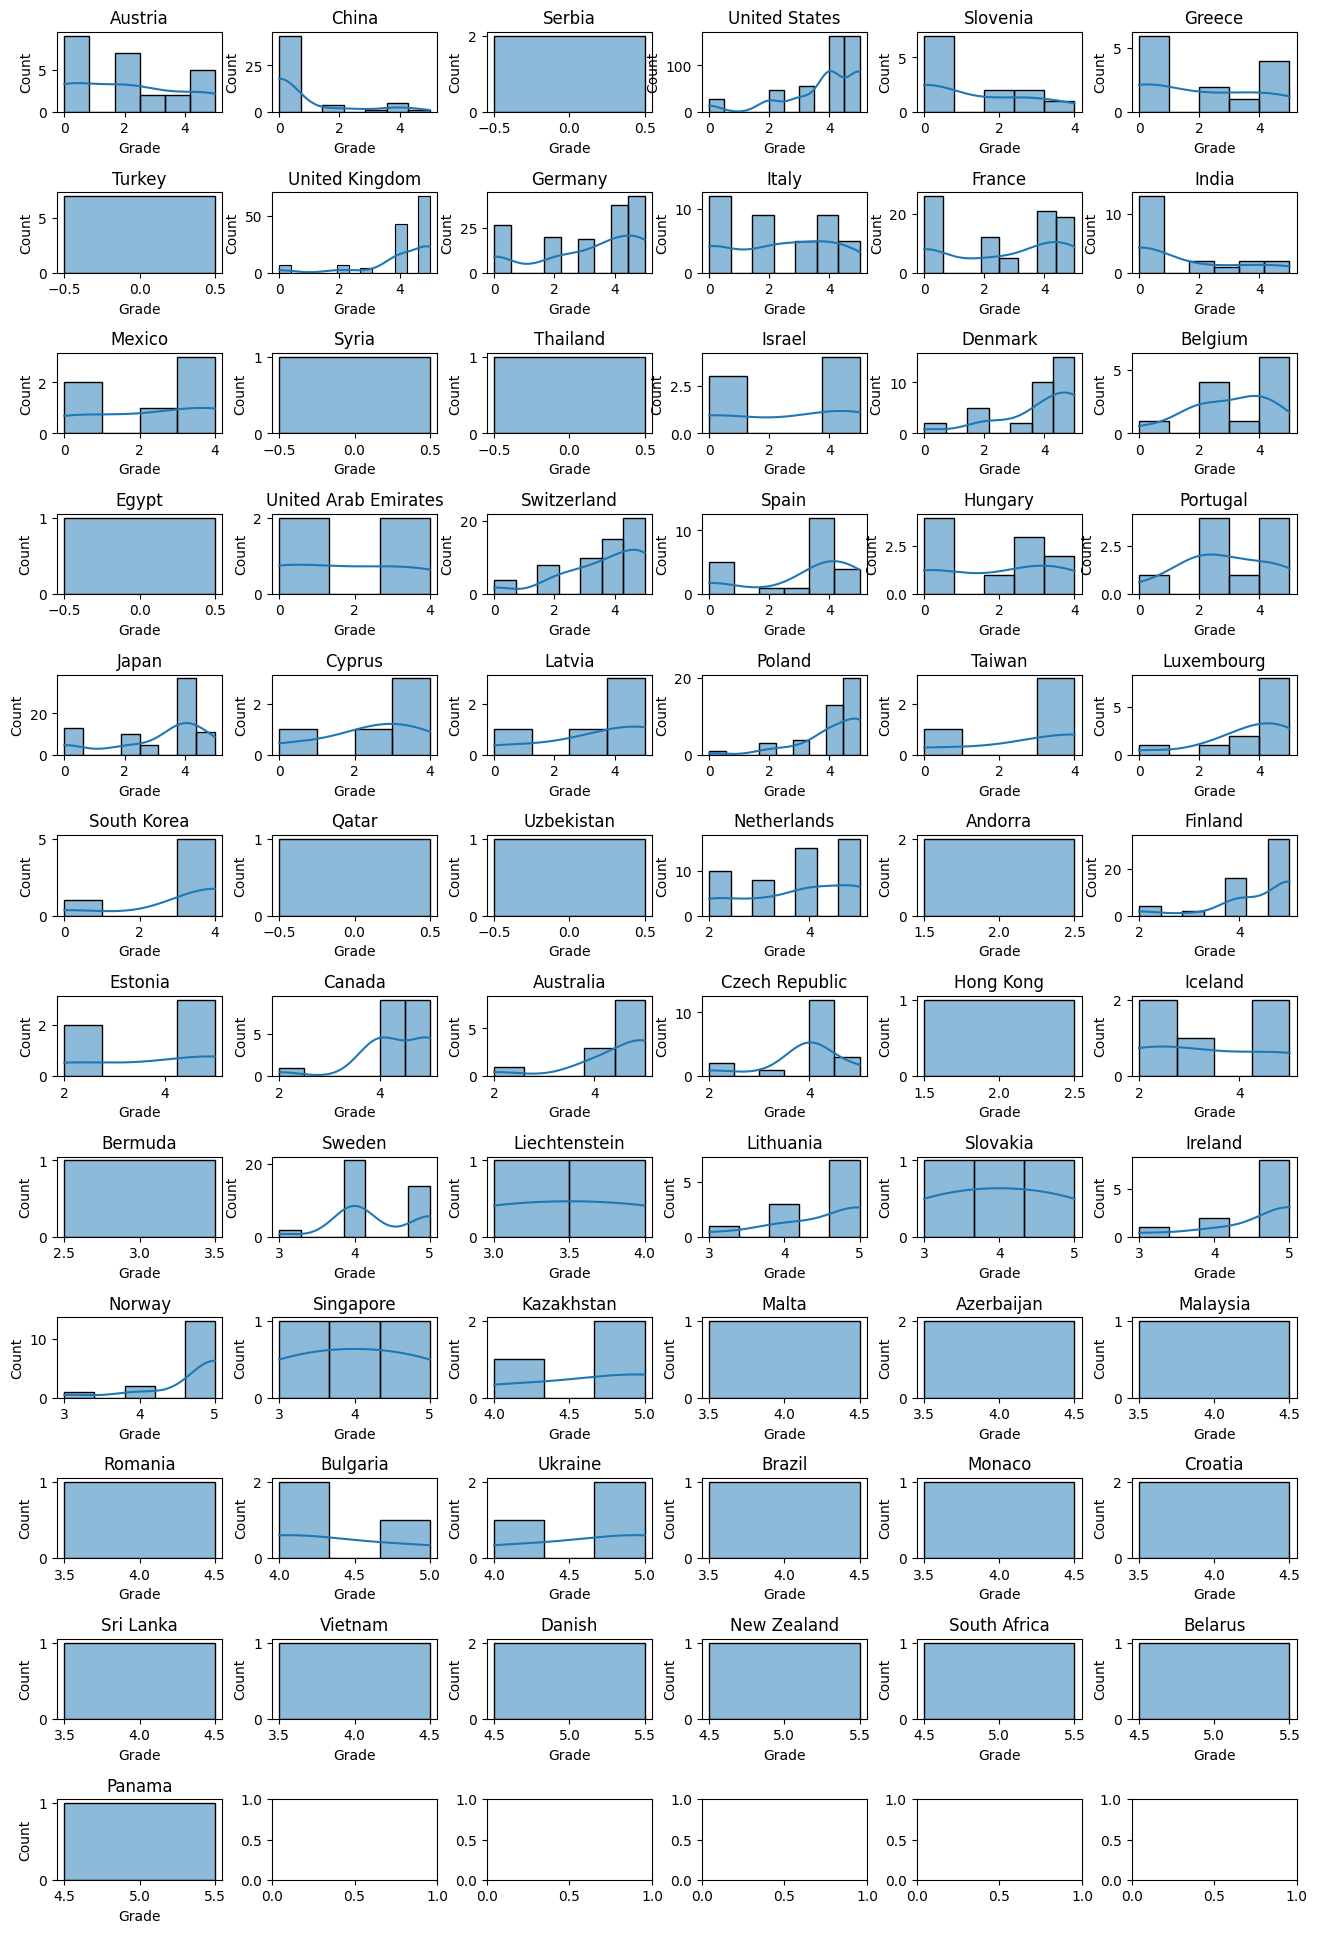

In [872]:
# China
media_china = dataframe[dataframe['Country'] == 'China']['Grade'].mean()
print(media_china)
grades_china = dataframe[dataframe['Country'] == 'China']['Grade']
sns.histplot(grades_china, kde=True)
plt.xlabel('Grade')
plt.ylabel('Frequência')
plt.title('Distribuição das Grades da China')
plt.show()

# Estados Unidos
media_china = dataframe[dataframe['Country'] == 'United States']['Grade'].mean()
print(media_china)
grades_china = dataframe[dataframe['Country'] == 'United States']['Grade']
sns.histplot(grades_china, kde=True)
plt.xlabel('Grade')
plt.ylabel('Frequência')
plt.title('Distribuição das Grades dos Estados Unidos')
plt.show()

# Todos os países
paises = dataframe['Country'].unique()

num_linhas = 12
num_colunas = 6 
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(16, 24))
plt.subplots_adjust(wspace=0.3, hspace=1)

for i, pais in enumerate(paises):
    grades_pais = dataframe[dataframe['Country'] == pais]['Grade']

    linha = i // num_colunas
    coluna = i % num_colunas

    sns.histplot(grades_pais, kde=True, ax=axs[linha, coluna])
    axs[linha, coluna].set_title(pais)

plt.show()


Outra análise que achei pertinente ser feita, é com base nas alianças comerciais firmadas, tendo em vista que os países da OTAN agem em sua maior forma contra forças Russas, e podemos observar que em sua maioria os países da OTAN encerraram suas atividades comerciais na Russia.

In [873]:
otan_countries = ['United States', 'Canada', 'Germany', 'France', 'United Kingdom', 'Italy', 'Netherlands',
                  'Belgium', 'Greece', 'Turkey', 'Portugal', 'Spain', 'Poland', 'Hungary', 'Czech Republic',
                  'Slovakia', 'Slovenia', 'Lithuania', 'Latvia', 'Estonia', 'Romania', 'Bulgaria', 'Croatia',
                  'Albania', 'Montenegro', 'North Macedonia']

dataframe['OTAN'] = dataframe['Country'].apply(lambda x: 1 if x in otan_countries else 0)
dataframe['OTAN'] = dataframe['OTAN'].apply(lambda x: 'OTAN=1' if x == 1 else 'OTAN=0')
dataframe['Grade'] = dataframe['Grade'].astype(str)
transactions = dataframe[['Country', 'OTAN', 'Grade']].values.tolist()

encoder = TransactionEncoder()

trans_encoded = encoder.fit_transform(transactions)
df_encoded = pd.DataFrame(trans_encoded, columns=encoder.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
otan_rules = rules[rules['antecedents'].apply(lambda x: 'OTAN=1' in x)]

print("Regras de associação para países membros da OTAN:")
print(otan_rules)
dataframe['Grade'] = dataframe['Grade'].astype(int)


Regras de associação para países membros da OTAN:
                  antecedents consequents  antecedent support  \
104        (OTAN=1, Slovenia)         (0)            0.007590   
108          (Turkey, OTAN=1)         (0)            0.004428   
160        (OTAN=1, Bulgaria)         (4)            0.001898   
165         (Croatia, OTAN=1)         (4)            0.001265   
168  (OTAN=1, Czech Republic)         (4)            0.011385   
201           (OTAN=1, Spain)         (4)            0.014548   
217         (OTAN=1, Estonia)         (5)            0.003163   
237          (Latvia, OTAN=1)         (5)            0.003163   
240       (Lithuania, OTAN=1)         (5)            0.006958   
256  (United Kingdom, OTAN=1)         (5)            0.080961   

     consequent support   support  confidence      lift  leverage  conviction  
104            0.146743  0.004428    0.583333  3.975216  0.003314    2.047818  
108            0.146743  0.004428    1.000000  6.814655  0.003778         

Por meio de análises feitas, constatamos que não há valores ausentes, valores aberrantes e nem inconsistências, a base é bem concisa.

In [874]:
def valoresInconsistentes(dataframe):
    valores_ausentes = dataframe.isnull().sum()

    colunas_desejadas = ['Name', 'Action', 'Industry', 'Country', 'Grade']
    dataframe_filtrado = dataframe[colunas_desejadas]

    tabela = pd.DataFrame(columns=['Aberrantes', 'Valores Ausentes'])
    quantidade_outliers = pd.Series(index=dataframe_filtrado.columns, dtype='float64')

    for coluna in dataframe_filtrado.columns:
        if dataframe_filtrado[coluna].dtype != 'object':
            coluna_zscore = np.abs(zscore(dataframe_filtrado[coluna].astype(float)))
            limite_zscore = 3
            outliers = (coluna_zscore > limite_zscore)
            quantidade_outliers[coluna] = outliers.sum()
            dataframe_filtrado[coluna] = dataframe_filtrado[coluna].mask(outliers, np.nan)

    tabela['Aberrantes'] = quantidade_outliers
    tabela['Valores Ausentes'] = valores_ausentes

    print(tabela)

# Chame a função passando o dataframe como argumento
valoresInconsistentes(dataframe)

          Aberrantes  Valores Ausentes
Name             NaN                 0
Action           NaN                 0
Industry         NaN                 0
Country          NaN                 0
Grade            0.0                 0


<ipython-input-874-b71ef47a3089>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_filtrado[coluna] = dataframe_filtrado[coluna].mask(outliers, np.nan)


Preenchendo os valores ausentes (Tentando atribuir o valor mais provável).

In [875]:
def verificar_dados_faltantes(df):

     # Verificar se há dados faltantes em cada coluna
    colunas_com_dados_faltantes = df.columns[df.isnull().any()].tolist()

    # Verificar se há dados faltantes na base de dados
    if df.isnull().values.any():
        print("A base de dados possui dados faltantes.")
        print("Colunas com dados faltantes:")
        for coluna in colunas_com_dados_faltantes:
            quantidade_faltante = df[coluna].isnull().sum()
            print(f"- {coluna}: {quantidade_faltante} valores faltantes")
    else:
        print("A base de dados não possui dados faltantes.")
    
verificar_dados_faltantes(dataframe)

A base de dados não possui dados faltantes.


In [876]:
# Verificando se há dados duplicados:
tem_duplicatas = dataframe.duplicated(subset='Name', keep=False)

# Exibindo as instâncias com o mesmo nome
instancias_duplicadas = dataframe[tem_duplicatas]

print(instancias_duplicadas)

Empty DataFrame
Columns: [Name, Action, Industry, Country, Grade, OTAN]
Index: []


Resolvendo as inconsistências, se houver.

Verificando se há valores inconsistente na coluna 'Grade', onde deve ter apenas as letras de A a F, e como pode-se observar não há valores inconsistentes.

In [877]:
for column in dataframe.columns:
    if column == 'Grade':
        values = dataframe[column].unique()
        for value in values:
            if value not in [0, 1, 2, 3, 4, 5]:
                print(f'Valor inconsistente: {value}')
print("FIM")

FIM


Transformando atributos categóricos nominais em um vetor numérico (por exemplo, usando o OneHotEncoder).

Optamos por usar a classe LabelEncoder pelo fato da base conter muitos valores distintos

In [878]:
# Colunas a serem alteradas
colunas_para_codificar = ['Action', 'Industry', 'Country']

# Inicializar o LabelEncoder
encoder = LabelEncoder()

# Iterar sobre as colunas e aplicar a codificação de rótulos
for coluna in colunas_para_codificar:
    dataframe[coluna] = encoder.fit_transform(dataframe[coluna])

# Imprimir o DataFrame resultante
dataframe.head()

,Name,Action,Industry,Country,Grade,OTAN
0,Agrana,342,2,2,0,OTAN=0
1,Agricultural Bank of China,136,4,10,0,OTAN=0
2,Air China,680,6,10,0,OTAN=0
3,Air Serbia,680,6,47,0,OTAN=0
4,Alibaba,694,1,10,0,OTAN=0


Fizemos um exempolo com OneHotEncode para demonstrar que fica muitos dados sem relevancia

In [879]:
df = pd.read_csv('companies.csv')

# Lista de colunas para codificar
colunas_para_codificar = ['Action', 'Industry', 'Country']

# Inicializar o OneHotEncoder
encoder = OneHotEncoder()

# Iterar sobre as colunas e aplicar a codificação one-hot
for coluna in colunas_para_codificar:
    # Extrair a coluna em um DataFrame separado
    coluna_df = pd.DataFrame(df[coluna])
    
    # Aplicar a codificação one-hot à coluna
    coluna_codificada = encoder.fit_transform(coluna_df).toarray()
    
    # Criar nomes de colunas codificadas
    nomes_colunas_codificadas = [f'{coluna}_{i}' for i in range(coluna_codificada.shape[1])]
    
    # Criar DataFrame com as colunas codificadas
    colunas_codificadas_df = pd.DataFrame(coluna_codificada, columns=nomes_colunas_codificadas)
    
    # Concatenar os DataFrames
    df = pd.concat([df, colunas_codificadas_df], axis=1)
    
    # Remover a coluna original
    df = df.drop(coluna, axis=1)

# Imprimir o DataFrame resultante
df.head()


,Name,Grade,Action_0,Action_1,Action_2,Action_3,Action_4,Action_5,Action_6,Action_7,...,Country_57,Country_58,Country_59,Country_60,Country_61,Country_62,Country_63,Country_64,Country_65,Country_66
0,Agrana,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agricultural Bank of China,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Air China,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Air Serbia,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alibaba,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Prints para comparação

In [880]:
originalDataFrame.head()

,Name,Action,Industry,Country,Grade
0,Agrana,continue operating plant in Russia,Consumer Staples,Austria,F
1,Agricultural Bank of China,Russian companies open accounts with the bank;...,Financials,China,F
2,Air China,still flying to Russia,Industrials,China,F
3,Air Serbia,still flying to Russia,Industrials,Serbia,F
4,Alibaba,still operating in Russia,Consumer Discretionary,China,F


In [881]:
dataframe.head()

,Name,Action,Industry,Country,Grade,OTAN
0,Agrana,342,2,2,0,OTAN=0
1,Agricultural Bank of China,136,4,10,0,OTAN=0
2,Air China,680,6,10,0,OTAN=0
3,Air Serbia,680,6,47,0,OTAN=0
4,Alibaba,694,1,10,0,OTAN=0
